# Exercises

### Code for data generation

In [1]:
## All the imports and general parameters

import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm import tqdm # to track your progress
import random
from scipy.stats import pearsonr

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


import seaborn as sns

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [2]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [3]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [4]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [5]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [6]:
def spike_decoding(t,x,spikes):
    ## Compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    ## Compute histograms for each cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    ## Generate the "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy

    ## Determine the spike position
    spikes_count = [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    ## Decoding procedure
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
        
    return true_x,x_decoded

In [7]:
def spike_preprocessing(t,x,spikes):
    ## Compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

    ## Compute histograms for each cell
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    ## Generate the "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy

    ## Determine the spike position
    spikes_count = [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    return space_bins, spikes_count, firing_rate_maps

In [8]:
def decoding_pmf(space_bins, spikes_count, firing_rate_maps,t,x,spikes):
    ## Decoding procedure
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
        
    return true_x,x_decoded

In [9]:
def decoding_logpmf(space_bins, spikes_count, firing_rate_maps,t,x,spikes):
    ## Decoding procedure
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
        
    return true_x,x_decoded

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [10]:
true_x, x_decoded = spike_decoding(t,x,spikes)

100%|██████████| 4238/4238 [00:08<00:00, 480.94it/s]


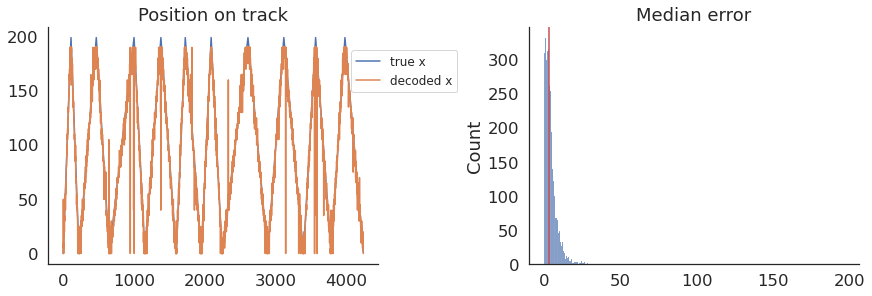

Median error: 3.431034482758621 cm


In [11]:
## Plot the whole track to see if we decoded the position properly as in the lecture notebook
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12,4))

axs[0].plot(true_x,label= 'true x')
axs[0].plot(x_decoded,label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.9, 0.7),fontsize=12)
axs[0].set_title('Position on track')

mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

#### A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

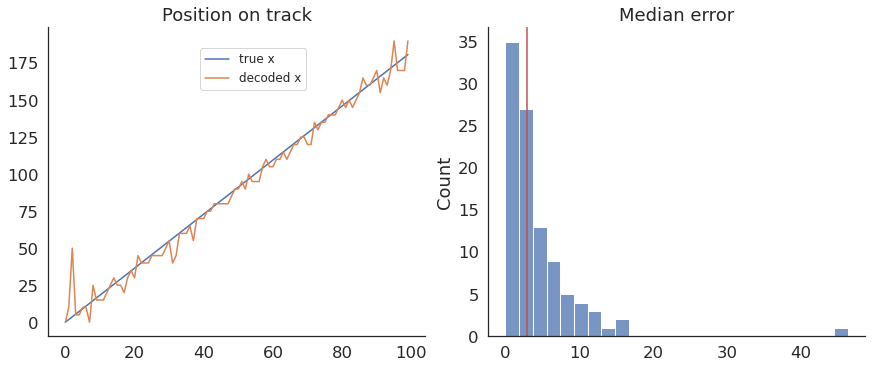

Median error: 2.8715596330275233 cm


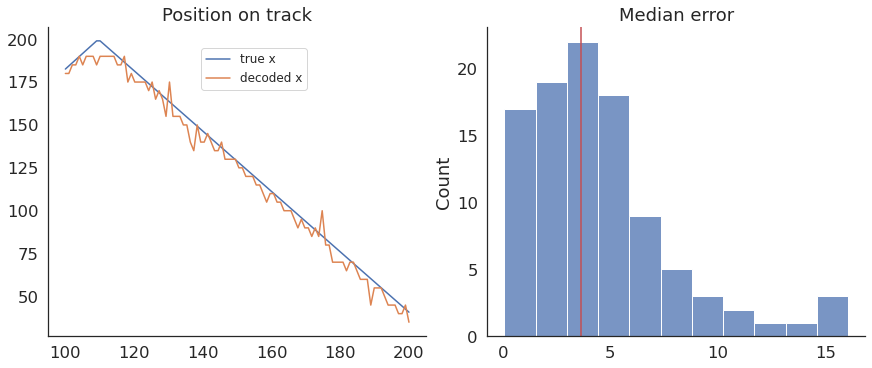

Median error: 3.6517857142857224 cm


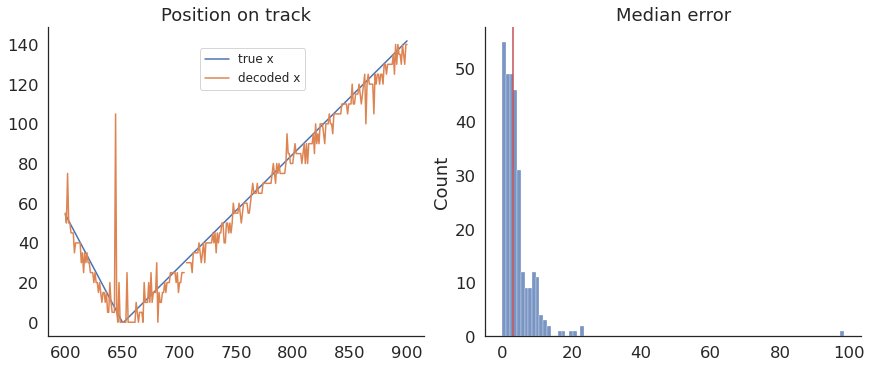

Median error: 3.1666666666666714 cm


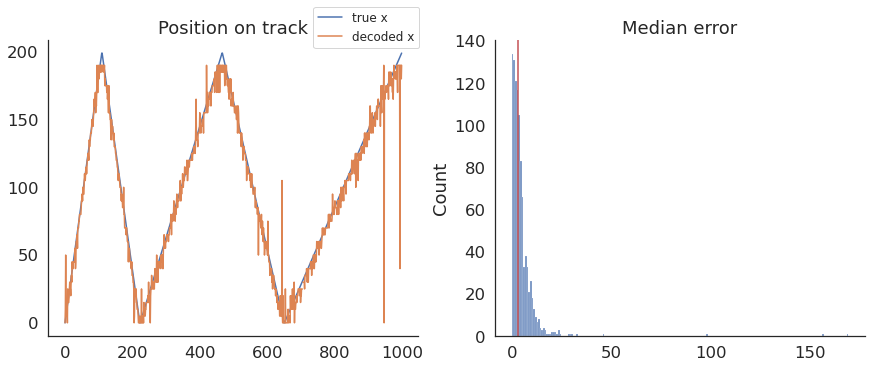

Median error: 3.3132183908046002 cm


In [12]:
## Error distribution for different fractions

## Smallest fraction between 0 and 100 s
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12, 5))

axs[0].plot(true_x[:100],label= 'true x')
axs[0].plot(x_decoded[:100],label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.7, 0.95),fontsize=12)
axs[0].set_title('Position on track')

mse = np.sqrt((true_x[:100]-x_decoded[:100])**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

## Smallest fraction between 100 and 200 s
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12, 5))

axs[0].plot(np.linspace(100,200,100),true_x[100:200],label= 'true x')
axs[0].plot(np.linspace(100,200,100),x_decoded[100:200],label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.7, 0.95),fontsize=12)
axs[0].set_title('Position on track')

mse = np.sqrt((true_x[100:200]-x_decoded[100:200])**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

## Small fraction between 600 and 900 s
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12, 5))

axs[0].plot(np.linspace(600,900,300),true_x[600:900],label= 'true x')
axs[0].plot(np.linspace(600,900,300),x_decoded[600:900],label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.7, 0.95),fontsize=12)
axs[0].set_title('Position on track')

mse = np.sqrt((true_x[600:900]-x_decoded[600:900])**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

## Larger fraction between 0 and 1000 s
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12, 5))

axs[0].plot(true_x[:1000],label= 'true x')
axs[0].plot(x_decoded[:1000],label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.7, 0.95),fontsize=12)
axs[0].set_title('Position on track')

mse = np.sqrt((true_x[:1000]-x_decoded[:1000])**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

In general the median error decreases slightly as the fraction becomes larger. However this is not always the case as there are fraction with more outliers than others. For example the fraction size for the upper two subfigures are the same but their median error can differs quite a bit.

#### B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

#### Decoding for 10 cells

In [13]:
## Choose randomly 10 cells and retrieve their spikes
index = random.sample(range(0, 99), 10)
spikes_10 = [spikes[i] for i in index]

true_x,x_decoded_10 = spike_decoding(t,x,spikes_10)

100%|██████████| 4238/4238 [00:03<00:00, 1281.25it/s]


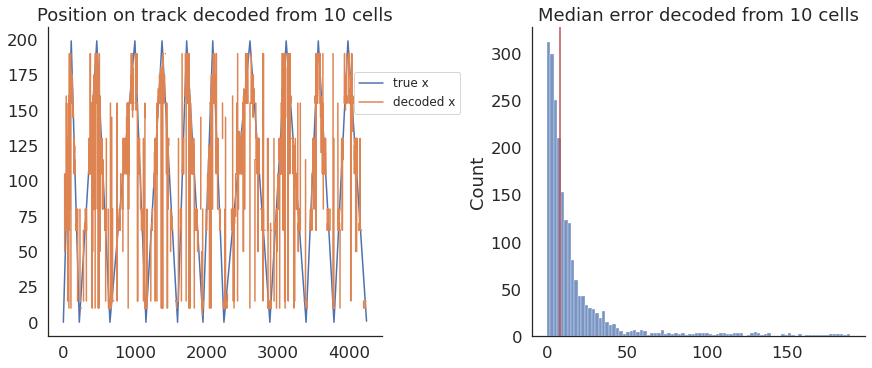

Median error: 8.19156837046745 cm


In [14]:
## Plot the position on the track and 
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(12,5))

axs[0].plot(true_x,label= 'true x')
axs[0].plot(x_decoded_10,label= 'decoded x')
axs[0].legend(bbox_to_anchor=(0.9, 0.7),fontsize=12)
axs[0].set_title('Position on track decoded from 10 cells')

mse = np.sqrt((true_x-x_decoded_10)**2)
sns.histplot(mse)
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('Median error decoded from 10 cells')
plt.show()

print(f'Median error: {np.nanmedian(mse)} cm')

#### Decoding for a bunch of different number of cells

In [15]:
## Choose randomly x cells and retrieve their spikes
n_cells_list = [1,10,15,20,30,40,50,60,70,80,90,95,99]
store_mse = []

for i in n_cells_list:
    index = random.sample(range(0, 99), i)
    spikes_sparse = [spikes[i] for i in index]

    true_x,x_decoded = spike_decoding(t,x,spikes_sparse)
    
    mse = np.sqrt((true_x-x_decoded)**2)
    store_mse.append(np.nanmedian(mse)) 

100%|██████████| 4238/4238 [00:08<00:00, 487.67it/s]


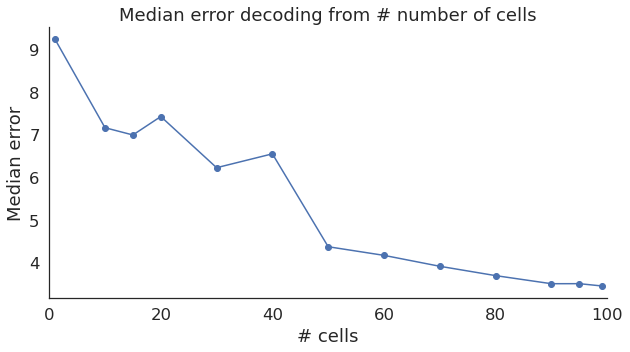

In [16]:
plt.plot(n_cells_list,store_mse,'o-')
plt.xlabel('# cells')
plt.ylabel('Median error')
plt.title('Median error decoding from # number of cells')
plt.xlim([0,100])
plt.show()

The median error decreases exponentionally and reaches its plateau around 100 cells. To reliably decode the position we need to sample at least 70 cells (median error of <5cm).

#### C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable noise firing_rate). How does this noise impact the decoding?

100%|██████████| 4238/4238 [00:08<00:00, 485.70it/s]


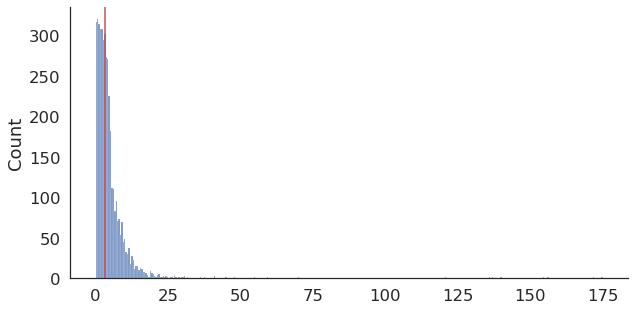

Median error: 3.357798165137609 cm


100%|██████████| 4238/4238 [00:08<00:00, 484.87it/s]


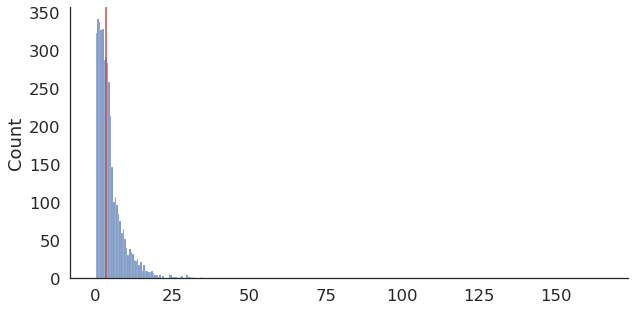

Median error: 3.4137931034482847 cm


100%|██████████| 4238/4238 [00:08<00:00, 485.30it/s]


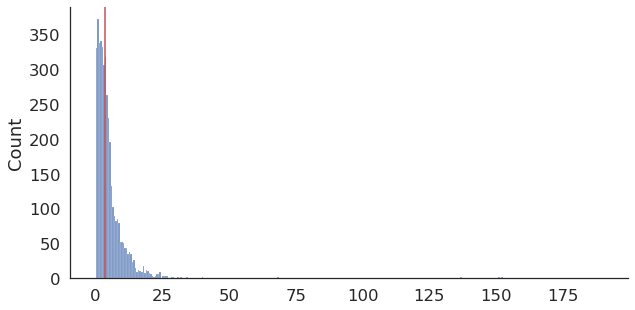

Median error: 3.581283049935095 cm


100%|██████████| 4238/4238 [00:08<00:00, 487.81it/s]


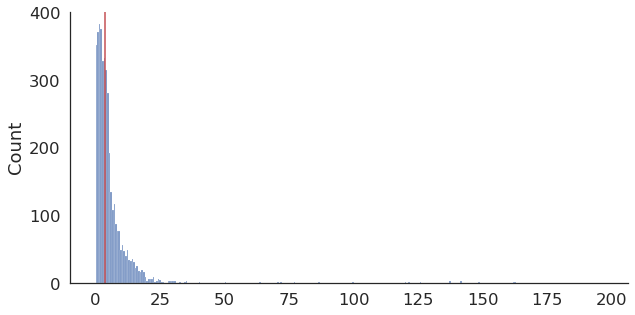

Median error: 3.7516257161938853 cm


100%|██████████| 4238/4238 [00:08<00:00, 487.69it/s]


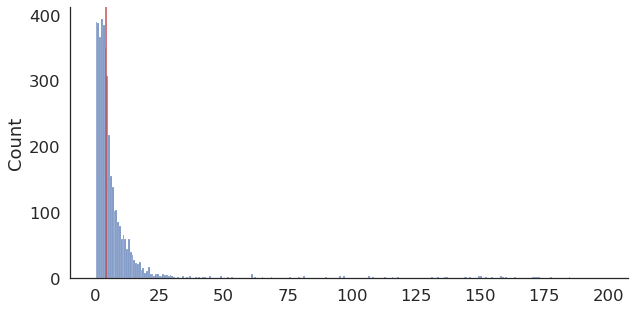

Median error: 3.884767002780201 cm


100%|██████████| 4238/4238 [00:08<00:00, 486.12it/s]


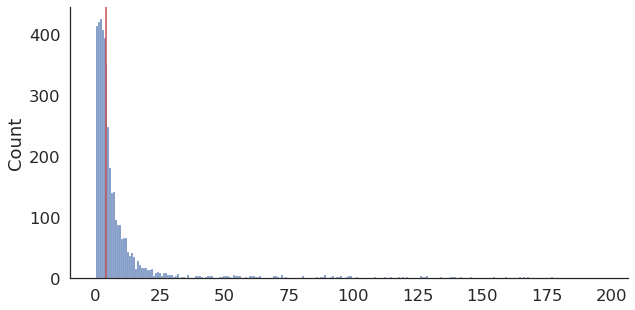

Median error: 3.982889180136894 cm


100%|██████████| 4238/4238 [00:08<00:00, 486.10it/s]


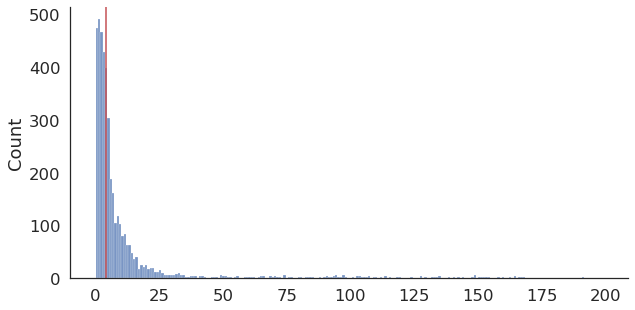

Median error: 4.243723552298988 cm


In [17]:
noise_levels = [0.1,0.2,0.4,0.7,1,1.5,2.]
mse_noise = []

for noise in noise_levels:
    noise_firing_rate = noise # the baseline noise firing rate
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
        
    true_x, x_decoded =  spike_decoding(t,x,spikes)
    
    mse = np.sqrt((true_x-x_decoded)**2)
    mse_noise.append(np.nanmedian(mse))
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    plt.show()
    print(f'Median error: {np.nanmedian(mse)} cm')

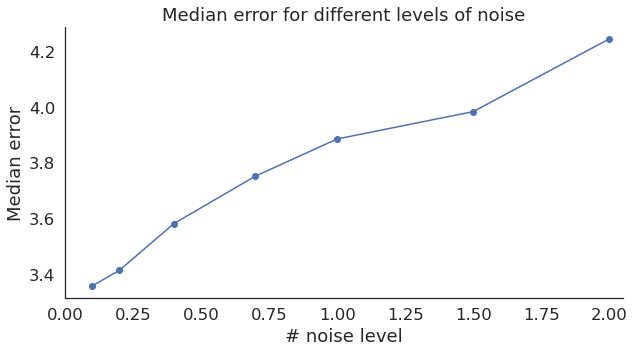

In [18]:
plt.plot(noise_levels,mse_noise,'o-')
plt.xlabel('# noise level')
plt.ylabel('Median error')
plt.title('Median error for different levels of noise')
plt.xlim([0,2.05])
plt.show()

Logically, as the level of noise increases, the median error increases.

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [19]:
## Generate spikes with a noise-level of 0.1 (optimal)
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [20]:
space_bins, spikes_count, firing_rate_maps = spike_preprocessing(t,x,spikes)

In [21]:
## Decoding method 1
true_x, decoded_x = decoding_pmf(space_bins, spikes_count, firing_rate_maps,t,x,spikes)

## Decoding method 2
true_x, decoded_xlog = decoding_logpmf(space_bins, spikes_count, firing_rate_maps,t,x,spikes)

100%|██████████| 4238/4238 [00:08<00:00, 487.55it/s]


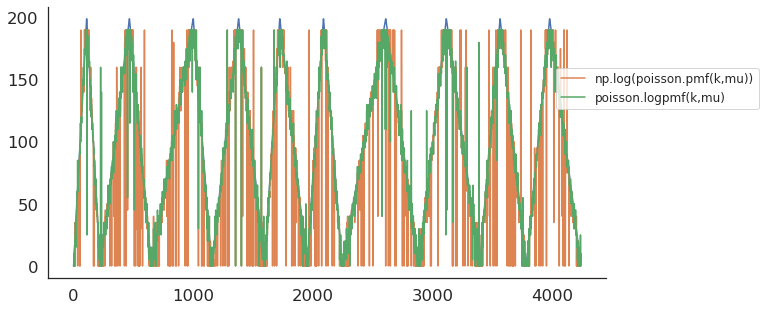

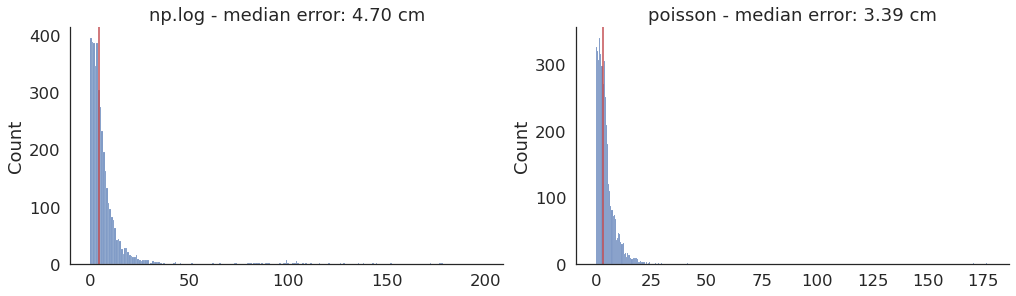

In [22]:
plt.plot(true_x)
plt.plot(decoded_x,label = 'np.log(poisson.pmf(k,mu))')
plt.plot(decoded_xlog,label = 'poisson.logpmf(k,mu)')
plt.legend(bbox_to_anchor=(0.9,0.6),fontsize=12)
plt.show()

## Plot the whole track to see if we decoded the position properly as in the lecture notebook
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(14,4))

mse = np.sqrt((true_x-decoded_x)**2)
sns.histplot(mse,ax=axs[0])
axs[0].axvline(x = np.nanmedian(mse),c='r')
axs[0].set_title('np.log - median error: %0.2f cm'%np.nanmedian(mse))

mse = np.sqrt((true_x-decoded_xlog)**2)
sns.histplot(mse,ax=axs[1])
axs[1].axvline(x = np.nanmedian(mse),c='r')
axs[1].set_title('poisson - median error: %0.2f cm'%np.nanmedian(mse))
plt.show()



The decoding method _np.log(poisson.pmf(k,mu))_ performs far worse than the method _poisson.logpmf(k,mu)_. Also the decoding time of this first method is roughly 1.5x longer. The method of _poisson.logpmf(k,mu)_ better handles outliers due to a build-in function.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


#### General functions

In [23]:
def generate_data(n_events=200,noise_x_react=5,noise_t_react=5):
    # generate data 
    event_duration = 100 # in bins
    sampling_rate = 100 # sampling rate 
    t_react = np.arange(0,100)
    noise_firing_rate = 0.1 # the baseline noise firing rate


    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))
    real_slopes = []

    for event in range(n_events):
        #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)
        real_slopes.append((x_end-x_start)/event_duration)

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length

        #store reactivation sequence
        reactivation_events[event,:] = x_react

        # Generate spikes according to the location being reactivated in this event    
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1
            
    return real_slopes,spikes_react

In [29]:
def estimate_reactivation(spikes_react,n_events=200):
    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
    return reactivation_slopes,reactivation_pvalues

In [25]:
def determine_falses(reactivation_slopes,real_slopes):
    false_negative = 0
    false_positive = 0

    for i in range(len(reactivation_slopes)):
        if real_slopes[i] > 0:
            if reactivation_slopes[i] < 0:
                false_negative += 1
        else:
            if reactivation_slopes[i] > 0:
                false_positive += 1
                
    return false_negative,false_positive

#### A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

In [31]:
# Perform the data preprocessing
n_events = 200
space_bins, spikes_count, firing_rate_maps = spike_preprocessing(t,x,spikes)

# Generate the spike data and determine the real slope
real_slopes,spikes_react = generate_data(n_events,noise_x_react=5,noise_t_react=5)

# Estimate reactivation from the spike data
reactivation_slopes,reactivation_pvalues = estimate_reactivation(spikes_react,n_events)

# Determine the false positives and false negatives
false_negative,false_positive = determine_falses(reactivation_slopes,real_slopes)
print('There are %s false positives and %s false negatives of all %s events'%(false_positive,false_negative,n_events))

There are 45 false positives and 1 false negatives of all 200 events


In [ ]:
plt.plot(reactivation_slopes/10)
plt.plot(np.asarray(real_slopes))
plt.yticks([])
plt.show()

#### B - Investigate the effect of noise_x_react and noise_t_react on the false positive rate and the false negative rate of our detection procedure.

In [32]:
## Reduce the noise_x_react:
# Generate the spike data and determine the real slope
real_slopes,spikes_react = generate_data(n_events=200,noise_x_react=25,noise_t_react=25)

# Estimate reactivation from the spike data
reactivation_slopes,reactivation_pvalues = estimate_reactivation(spikes_react,n_events)

# Determine the false positives and false negatives
false_negative,false_positive = determine_falses(reactivation_slopes,real_slopes)
print('There are %s false positives and %s false negatives of all %s events'%(false_positive,false_negative,n_events))

There are 69 false positives and 16 false negatives of all 200 events


In [34]:
# Calculate the amount of false positives and negatives for different levels of position-noise 
# averaged across three registrations
noise_x = [1,5,10,15,20,25,30]
x_negatives = []
x_positives = []
iterations = 3

for i in noise_x:
    false_negatives = []
    false_positives = []
    for j in range(iterations):
        # Generate the spike data and determine the real slope
        real_slopes,spikes_react = generate_data(n_events,noise_x_react=i,noise_t_react=5)

        # Estimate reactivation from the spike data
        reactivation_slopes,reactivation_pvalues = estimate_reactivation(spikes_react,n_events)

        # Determine the false positives and false negatives
        false_negative,false_positive = determine_falses(reactivation_slopes,real_slopes) 

        false_negatives.append(false_negative)
        false_positives.append(false_positive)
        
    x_negatives.append(sum(np.asarray(false_negatives))/iterations)
    x_positives.append(sum(np.asarray(false_positives))/iterations)   

In [35]:
# Calculate the amount of false positives and negatives for different levels of position-noise 
# averaged across three registrations
noise_t = [1,5,10,15,20,25,30]
t_negatives = []
t_positives = []
iterations = 3

for i in noise_x:
    false_negatives = []
    false_positives = []
    for j in range(iterations):
        # Generate the spike data and determine the real slope
        real_slopes,spikes_react = generate_data(n_events,noise_x_react=5,noise_t_react=i)

        # Estimate reactivation from the spike data
        reactivation_slopes,reactivation_pvalues = estimate_reactivation(spikes_react,n_events)

        # Determine the false positives and false negatives
        false_negative,false_positive = determine_falses(reactivation_slopes,real_slopes) 

        false_negatives.append(false_negative)
        false_positives.append(false_positive)
        
    t_negatives.append(sum(np.asarray(false_negatives))/iterations)
    t_positives.append(sum(np.asarray(false_positives))/iterations)   

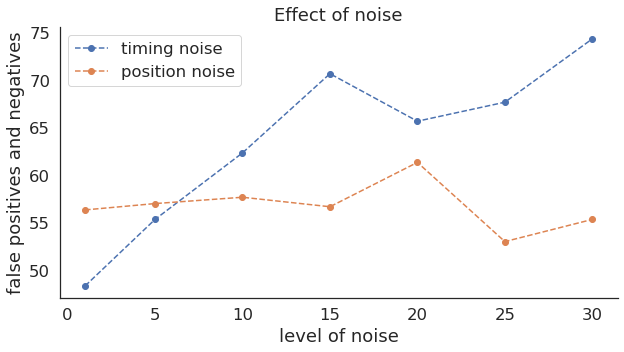

In [37]:
plt.plot(noise_t,np.array(t_negatives)+np.array(t_positives),'o--',label = 'timing noise')
plt.plot(noise_x,np.array(x_negatives)+np.array(x_positives),'o--',label = 'position noise')
plt.title('Effect of noise')
plt.legend()
plt.xlabel('level of noise')
plt.ylabel('false positives and negatives')
plt.show()

#### C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?

Adding noise to the position of the spike, does not seem to affect the sequence detection methods. Adding noise to the timing of the spike does affect the detection method. We could detect the timing of a sequential.